In [31]:
import pandas as pd
import numpy as np
import networkx as nx
import json
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [32]:
# Load data
package_feats = json.load(open('./dataset/package-features.json'))
project_data = json.load(open("./GithubScrape/Data/50_topics_filtered/append_dependencies_50.json"))

In [33]:
print(len(project_data.keys()))

457


In [34]:
project_data

{'homepage': {'@eslint-community/eslint-utils': '4.4.0',
  '@humanwhocodes/module-importer': '1.0.1',
  '@isaacs/cliui': '8.0.2',
  '@nodelib/fs.scandir': '2.1.5',
  '@nodelib/fs.stat': '2.0.5',
  '@nodelib/fs.walk': '1.2.8',
  '@types/json5': '0.0.29',
  '@ungap/structured-clone': '1.2.0',
  'acorn-jsx': '5.3.2',
  'ansi-regex': '5.0.1',
  'ansi-styles': '4.3.0',
  'argparse': '2.0.1',
  'aria-query': '5.1.3',
  'array-union': '2.1.0',
  'array.prototype.flat': '1.3.2',
  'array.prototype.flatmap': '1.3.2',
  'asynckit': '0.4.0',
  'base64-js': '1.5.1',
  'bl': '4.1.0',
  'boolbase': '1.0.0',
  'brace-expansion': '1.1.11',
  'buffer': '5.7.1',
  'bytes': '3.1.2',
  'callsites': '3.1.0',
  'chalk': '4.1.2',
  'chownr': '2.0.0',
  'color-convert': '2.0.1',
  'color-name': '1.1.3',
  'combined-stream': '1.0.8',
  'commander': '6.2.1',
  'concat-map': '0.0.1',
  'cross-spawn': '7.0.3',
  'css-what': '6.1.0',
  'cssesc': '3.0.0',
  'd3-array': '3.2.4',
  'd3-color': '3.1.0',
  'd3-interpol

In [5]:
# For each project remove dependencies that are not available
def clean_project_data(data, valid):
    for project, deps in data.items():
        data[project] = [p for p in deps.keys() if p in valid]
        
clean_project_data(project_data, package_feats.keys())

In [6]:
def create_package_list(data):
    packages = set()
    for deps in data.values():
        packages.update(deps)
    return list(packages)

In [38]:
def create_ground_truth_matrix(data):
    package_list = create_package_list(project_data)
    package_list.sort()
    project_names = sorted(data.keys())
    
    gt_mat = np.zeros((len(project_names), len(package_list)))
    
    for i, project in enumerate(project_names):
        for pkg in data[project]:
            if pkg in package_list:
                j = package_list.index(pkg)
                gt_mat[i, j] = 1
                    
    return gt_mat, package_list, project_names
                
ground_truth, package_order, project_order = create_ground_truth_matrix(project_data)

In [39]:
print(ground_truth.shape)

(457, 16670)


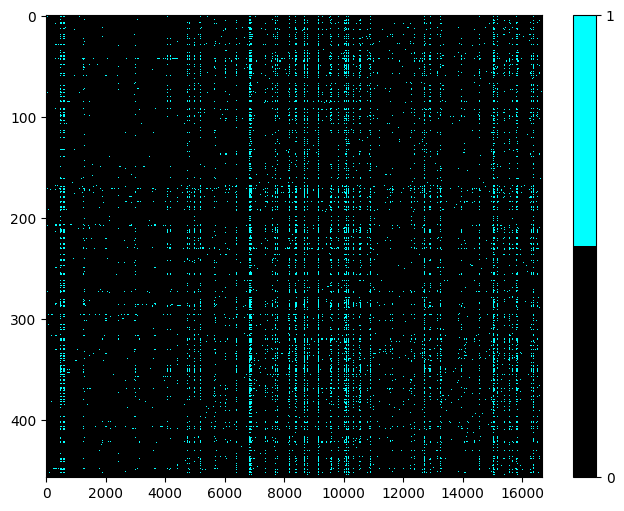

In [47]:
def visualize_matrix(mat, colors=('black', 'cyan')):
    cmap = ListedColormap(colors)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(mat, cmap=cmap, interpolation='nearest', aspect='auto')
    
    cbar = plt.colorbar(ticks=[0, 1,])
    cbar.ax.set_yticklabels(['0', '1'])
    
    plt.show()
    
visualize_matrix(ground_truth)

In [41]:
np.random.seed(42)  # For reproducibility

# Function to mask a percentage of values
def mask_matrix(matrix, mask_percentage):
    masked_matrix = matrix.copy()
    total_elements = matrix.size
    num_to_mask = int(total_elements * mask_percentage / 100)
    
    # Get random indices to mask
    indices = np.random.choice(total_elements, num_to_mask, replace=False)
    rows, cols = np.unravel_index(indices, matrix.shape)
    
    # Mask selected values
    masked_matrix[rows, cols] = np.nan  # Replace with 0 (or np.nan if preferred)
    return masked_matrix

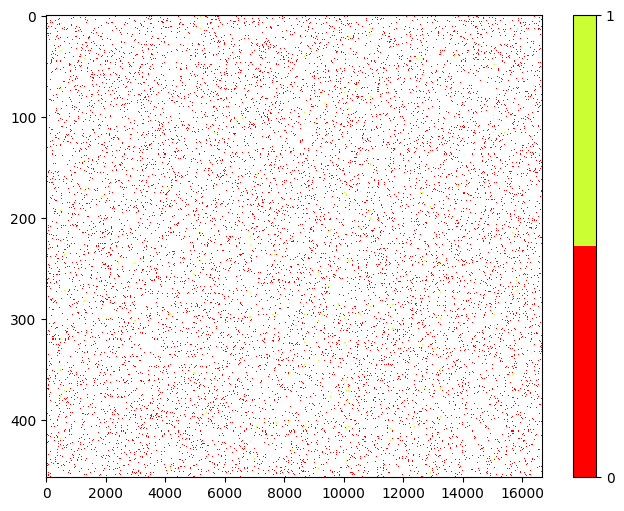

In [42]:
training_matrix = mask_matrix(ground_truth, 95)
visualize_matrix(training_matrix)

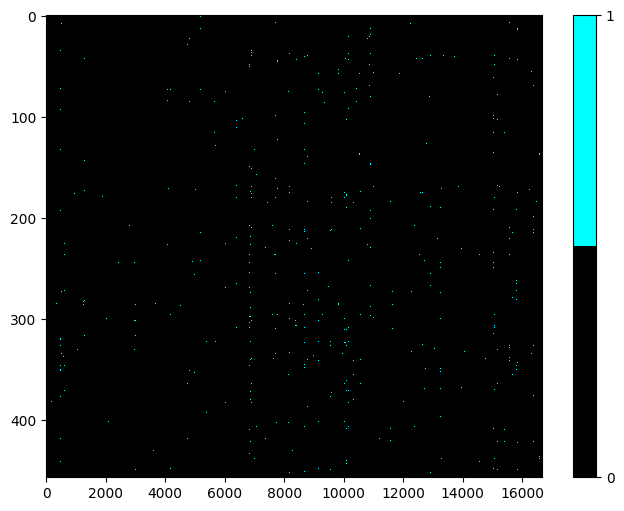

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def predict_with_collaborative_filtering(training_matrix, similarity_type):
    """
    Perform collaborative filtering to predict missing values (NaN) in the training matrix.
    
    Args:
        training_matrix (ndarray): Input matrix with NaN as missing values.
        similarity_type (str): 'item' for item-based similarity, 'user' for user-based similarity.

    Returns:
        ndarray: Matrix with predicted values replacing NaN.
    """
    # Copy the matrix to avoid modifying the original
    matrix = training_matrix.copy()
    
    # Replace NaN with 0 for similarity calculations
    nan_mask = np.isnan(matrix)
    matrix[nan_mask] = 0
    
    # Compute similarity
    if similarity_type == 'item':
        similarity = cosine_similarity(matrix.T)  # Item-item similarity
        mean_ratings = np.nanmean(training_matrix, axis=0)  # Item-wise mean
        prediction = np.dot(matrix, similarity) / (np.abs(similarity).sum(axis=1) + 1e-8)
    elif similarity_type == 'user':
        similarity = cosine_similarity(matrix)  # User-user similarity
        mean_ratings = np.nanmean(training_matrix, axis=1)  # User-wise mean
        prediction = np.dot(similarity, matrix) / (np.abs(similarity).sum(axis=1)[:, np.newaxis] + 1e-8)
    else:
        raise ValueError("Invalid similarity_type. Use 'item' or 'user'.")

    # Add back the mean to predictions
    if similarity_type == 'item':
        prediction += mean_ratings[np.newaxis, :]
    else:
        prediction += mean_ratings[:, np.newaxis]
    
    # Restore NaN positions with predicted values
    training_matrix[nan_mask] = prediction[nan_mask]
    return training_matrix

def evaluate_predictions(predicted, ground_truth, mask):
    """
    Evaluate the prediction matrix against the ground truth.

    Args:
        predicted (ndarray): Predicted matrix.
        ground_truth (ndarray): Ground truth matrix.
        mask (ndarray): Boolean mask of where values were originally missing.

    Returns:
        float: Mean Absolute Error (MAE) of predictions.
    """
    # Ensure mask has valid indices
    if not np.any(mask):
        raise ValueError("Mask is empty. No masked values to evaluate.")

    # Compute the error only for masked positions
    error = np.abs(predicted[mask] - ground_truth[mask])
    
    # If the error array is empty, raise a warning or return NaN
    if error.size == 0:
        raise ValueError("Error array is empty. Check your mask and ground_truth alignment.")

    return error.mean()


# Example usage:
# Assume training_matrix and ground_truth are already defined
predicted_matrix = predict_with_collaborative_filtering(training_matrix, similarity_type='item')



visualize_matrix(predicted_matrix)



In [50]:
def reconstruction_error(original, test):
    
    # Apply the mask to calculate the error only on specified elements
    difference = original - test
    squared_error = np.square(difference)
    mean_squared_error = np.mean(squared_error)
    rmse = np.sqrt(mean_squared_error)
    
    return rmse


In [51]:
reconstruction_error(ground_truth, predicted_matrix)

np.float64(0.1670140150238655)

In [53]:
reconstruction_error(ground_truth,np.zeros(predicted_matrix.shape))
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def predict_with_collaborative_filtering(training_matrix, similarity_type='item', k=10):
    """
    Perform collaborative filtering to predict missing values (NaN) in the training matrix.

    Args:
        training_matrix (ndarray): Input matrix with NaN as missing values.
        similarity_type (str): 'item' for item-based similarity, 'user' for user-based similarity.
        k (int): Number of nearest neighbors to consider for prediction.

    Returns:
        ndarray: Matrix with predicted values replacing NaN.
    """
    # Copy the matrix to avoid modifying the original
    matrix = training_matrix.copy()
    
    # Replace NaN with 0 for similarity calculations
    nan_mask = np.isnan(matrix)
    matrix[nan_mask] = 0
    
    # Compute similarity
    if similarity_type == 'item':
        similarity = cosine_similarity(matrix.T)  # Item-item similarity
        mean_ratings = np.nanmean(training_matrix, axis=0)  # Item-wise mean
        centered_matrix = matrix - mean_ratings[np.newaxis, :]
    elif similarity_type == 'user':
        similarity = cosine_similarity(matrix)  # User-user similarity
        mean_ratings = np.nanmean(training_matrix, axis=1)  # User-wise mean
        centered_matrix = (matrix.T - mean_ratings[:, np.newaxis]).T
    else:
        raise ValueError("Invalid similarity_type. Use 'item' or 'user'.")

    # Regularize similarity to reduce impact of high similarity with few items/users
    similarity += np.eye(similarity.shape[0]) * 1e-8  # Add small value to diagonal to avoid divide by zero

    # Restrict to k nearest neighbors
    if k > 0:
        for i in range(similarity.shape[0]):
            top_k_indices = np.argsort(similarity[i])[-k:]  # Indices of top k neighbors
            similarity[i, np.setdiff1d(np.arange(similarity.shape[0]), top_k_indices)] = 0

    # Normalize similarity matrix
    similarity = similarity / (np.abs(similarity).sum(axis=1, keepdims=True) + 1e-8)

    # Make predictions
    if similarity_type == 'item':
        prediction = np.dot(matrix, similarity)
        prediction += mean_ratings[np.newaxis, :]  # Add mean back
    else:
        prediction = np.dot(similarity, matrix)
        prediction += mean_ratings[:, np.newaxis]  # Add mean back
    
    # Restore NaN positions with predicted values
    training_matrix[nan_mask] = prediction[nan_mask]
    return training_matrix


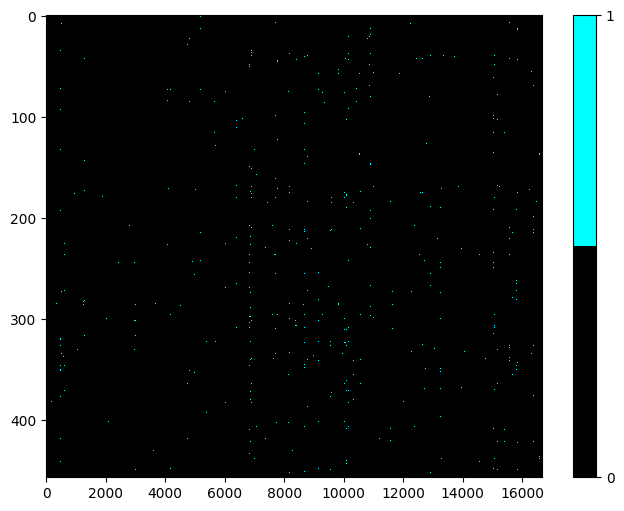

In [54]:
# Predict using improved item-based collaborative filtering
predicted_matrix = predict_with_collaborative_filtering(training_matrix, similarity_type='item', k=10)

# Optionally visualize the predicted matrix
visualize_matrix(predicted_matrix)

# # Evaluate predictions
# masked_values_mask = np.isnan(training_matrix)
# mae = evaluate_predictions(predicted_matrix, ground_truth, masked_values_mask)
# print(f"Improved Mean Absolute Error (MAE): {mae:.4f}")


In [55]:
reconstruction_error(ground_truth, predicted_matrix)

np.float64(0.1670140150238655)